# 정형 데이터 분석

## 영화평점 데이터 분석과 시각화

### 분석의 목적

- 네이버 영화 평점 데이터 수집의 문제점 여부 점검
- 영화별 날짜 변화에 따른 평점 변화 확인
- 특정 영화의 미래 날짜 평점을 예측 또는 영화 추첨 모델의 훈련 기초 데이터 생성

### 분석 사례

#### 데이터 수집

In [ ]:
# 한글 시각화 준비 (Colab인 경우는 필수 실행)
# 특수한 상황이 아닌 경우 오류 없이 실행됨
# 아래 코드 실행 후 Colab 메뉴에서 <런타임> - <런타임 다시시작> 해야함.
!apt-get install fonts-nanum* # 리눅스 시스템에 font 설치 명령어
!fc-cache -fv  # font 시스템 캐쉬 삭제 명령어
!rm -rf ~/.cache/matplotlib/*  # 파이썬 font 캐쉬 삭제 명령어

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-gothic-light' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
fonts-nanum is already the newest version (20180306-3).
fonts-nanum-coding is already the newest version (2.5-2).
fonts-nanum-eco is already the newest version (1.000-7).
fonts-nanum-extra is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/

In [ ]:
# 기본 패키지 로드
import pandas as pd
import numpy as np

# 시각화 패키지 로드
import matplotlib.pyplot as plt
import seaborn as sns

# 웹 스크래핑(크롤링) 필요 패키지 로드
import requests
from bs4 import BeautifulSoup

# 기타 패키지 로드
from tqdm import tqdm # 진행바 출력 

In [ ]:
# 한글 시각화 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False


##### Naver 영화 평점

- 웹 스크래핑 또는 웹 크롤링의 단점 사례를 살펴보는 예제제
    - 변경 대응력 : 기본적으로 HTML의 경우 DOM 기반이기 때문에 수정에 따른 유지보수 비용 발생
    - 보안 : 인증처리가 필요한 스크래핑의 경우 비밀번호가 저장됨(타인)
    - 개인정보 침해 : 스크래핑 프로그램이 요구되는 정보 이외를 수집
    - 웹 제약 : 모바일로 서비스되는 앱에 노출되는 데이터는 접근 불가
    - 통제와 고위험 : 프로그램이 통제되지 않는 경우 필요 이상의 서버 부하 발생

###### 단건 데이터 수집

In [ ]:
# 스크래핑을 위한 사이트 접속 및 데이터 요청
movie_url = "http://movie.naver.com/movie/sdb/rank/rmovie.nhn?sel=cur&date=20221231"
movie_page = requests.get(movie_url)
soup = BeautifulSoup(movie_page.content, "html.parser")
soup

In [ ]:
# 수집 대상 정보(영화명) 검색해 보기
soup.find_all('div', 'tit5')

In [ ]:
# 수집 대상 정보(영화명)를 모두 검색
movie_count = len(soup.find_all('div', 'tit5'))

In [ ]:
# 수집 대상 정보(영화명) 중 첫번째 정보 보기
soup.find_all('div', 'tit5')[0]

In [ ]:
# 수집 대상 정보(영화명) 중 첫번째 정보에서 원하는 정보를 포함하는 Tag 추출
soup.find_all('div', 'tit5')[0].a

In [ ]:
# 수집 대상 정보(영화명) 중 첫번째 정보에서 원하는 정보를 포함하는 Tag에서 실질 데이터 문자열 추출
soup.find_all('div', 'tit5')[0].a.string

In [ ]:
# 수집 대상 정보(영화명) 모두에서 원하는 정보를 포함하는 Tag에서 실질 데이터 문자열 추출
movie_name = [soup.find_all('div', 'tit5')[n].a.string for n in range(0, 37)]

In [ ]:
# 수집 대상 정보(평점) 중 첫번째 정보에서 원하는 정보를 포함하는 Tag에서 실질 데이터 문자열 추출
soup.find_all('td', 'point')[0].string

In [ ]:
# 수집 대상 정보(평점) 모두에서 원하는 정보를 포함하는 Tag에서 실질 데이터 문자열 추출
movie_point = [soup.find_all('td', 'point')[n].string for n in range(0, 37)]

###### 실제 데이터 수집

In [ ]:
# 필요기간 : 2020/01/01 ~ 2020/12/31 
# 날짜 정보를 생성
date_terms = pd.date_range('20200101', '20201231')

In [ ]:
# 단건 데이터 수집 코드를 참조하여 필요기간의 영화 평점 정보를 수집하는 반복 프로그램
# 수집 데이터는 날짜, 영화명, 평점, 순위 4가지 정보
movie_date = []
movie_name = []
movie_point = []
movie_rank = []
for target_ymd in tqdm(date_terms):
    target_ymd = target_ymd.strftime('%Y%m%d')
    movie_url = f"http://movie.naver.com/movie/sdb/rank/rmovie.nhn?sel=cur&date={target_ymd}"
    movie_page = requests.get(movie_url)
    soup = BeautifulSoup(movie_page.content, "html.parser")
    movie_count = len(soup.find_all('div', 'tit5'))
    # 날짜
    movie_date.extend([target_ymd for n in range(0, movie_count)])
    # 영화명
    movie_name.extend([soup.find_all('div', 'tit5')[n].a.string for n in range(0, movie_count)])
    # 평점
    movie_point.extend([soup.find_all('td', 'point')[n].string for n in range(0, movie_count)])
    # 순위
    movie_rank.extend([n for n in range(0, movie_count)])


In [ ]:
# 수집된 데이터 건수 확인 : 정상이라면 모든 건수가 동일해야 함.
len(movie_date), len(movie_name), len(movie_point), len(movie_rank)

In [ ]:
# 수집된 데이터를 pandas 데이터 프레임으로 변환
movie = pd.DataFrame({'date':movie_date, 'name':movie_name, 'point':movie_point, 'rank': movie_rank})
movie.head()

In [ ]:
# 분석을 위하여 수집데이터 저장
movie.to_csv('naver_movie_2020.csv', index=False)

##### Daum 영화평점

###### 단건 데이터 수집

In [ ]:
# 기본 정보 스크래핑을 위한 사이트 접속 및 데이터 요청
movie_url = "https://movie.daum.net/ranking/boxoffice/weekly?date=20200101"
movie_page = requests.get(movie_url)
soup = BeautifulSoup(movie_page.content, "html.parser")
soup

In [ ]:
# 수집 대상 정보(영화명) 검색해 보기
soup.find_all('strong', 'tit_item')

In [ ]:
# 수집 대상 정보(영화명) 중 첫번째 정보에서 원하는 정보를 포함하는 Tag 추출
soup.find_all('strong', 'tit_item')[0].a

In [ ]:
# 수집 대상 정보(영화명) 중 첫번째 정보에서 원하는 정보를 포함하는 Tag에서 실질 데이터 문자열 추출
soup.find_all('strong', 'tit_item')[0].a.string

In [ ]:
# 수집 대상 정보(상세링크) 중 첫번째 정보에서 원하는 정보를 포함하는 Tag에서 실질 데이터 문자열 추출
detail_link = soup.find_all('strong', 'tit_item')[0].a['href']
detail_link

In [ ]:
# 수집 대상 정보(개봉일, 관객수) 검색해 보기
soup.find_all('span', 'info_txt')

In [ ]:
# 수집 대상 정보(개봉일) 중 첫번째 정보에서 원하는 정보를 포함하는 Tag에서 실질 데이터 문자열 추출
soup.find_all('span', 'info_txt')[0].span.string

In [ ]:
# 수집 대상 정보(관객수) 중 첫번째 정보에서 원하는 정보를 포함하는 Tag에서 실질 데이터 문자열 추출
str(soup.find_all('span', 'info_txt')[1]).split('</span>')[1].split('명')[0].replace(',', '')

In [ ]:
# 추가 정보 스크래핑을 위한 사이트 접속 및 데이터 요청
movie_url = "https://movie.daum.net/moviedb/main?movieId=127153"
movie_page = requests.get(movie_url)
soup = BeautifulSoup(movie_page.content, "html.parser")
soup

In [ ]:
# 개봉일
str(soup.find_all('dl', 'list_cont')).split('<dt>개봉</dt>')[1].split('<dd>')[1].split('</dd>')[0]

In [ ]:
# 다른 방법으로 개봉일 정보에 접근
soup.find_all('dd')[0].string, soup.find_all('dd')[0].text

In [ ]:
# 평점
str(soup.find_all('dl', 'list_cont')).split('<dt>평점</dt>')[1].split('</span>')[1].split('</dd>')[0]

In [ ]:
# 누적관객
str(soup.find_all('dl', 'list_cont')).split('<dt>누적관객</dt>')[1].split('<dd>')[1].split('</dd>')[0].replace('명', '').replace(',', '')

###### 실제 데이터 수집

In [ ]:
# 필요기간 : 2020/01/01 ~ 2020/12/31 
# 날짜 정보를 생성 : Daum 사이트는 일주일 단위로 영화 정보가 조회됨
date_terms = pd.date_range('20200101', '20201231', freq='7D')
date_terms

In [ ]:
# 단건 데이터 수집 코드를 참조하여 필요기간의 영화 평점 정보를 수집하는 반복 프로그램
# 수집 데이터는 수집일, 영화명, 상세정보 링크, 개봉일, 평점, 누적관객수, 순위 7가지 정보
movie_date = []
movie_name = []
movie_detaillink = []
movie_open = []
movie_point = []
movie_guest = []
movie_rank = []
for target_ymd in tqdm(date_terms):
    target_ymd = target_ymd.strftime('%Y%m%d')
    ### 기본 정보 수집
    movie_url = f"https://movie.daum.net/ranking/boxoffice/weekly?date={target_ymd}"
    movie_page = requests.get(movie_url)
    soup = BeautifulSoup(movie_page.content, "html.parser")
    movie_count = len(soup.find_all('strong', 'tit_item'))
    # 날짜
    movie_date.extend([target_ymd for n in range(0, movie_count)])
    # 영화명
    movie_name.extend([soup.find_all('strong', 'tit_item')[n].a.string for n in range(0, movie_count)])
    # 상세링크
    movie_detaillink.extend([soup.find_all('strong', 'tit_item')[n].a['href'] for n in range(0, movie_count)])
    ### 상세 링크 접속 후 데이터 추가 수집
    for detail_url in movie_detaillink:
        movie_url = f"https://movie.daum.net{detail_url}"
        movie_page = requests.get(movie_url)
        soup = BeautifulSoup(movie_page.content, "html.parser")
        # 개봉일
        try:
            movie_open.append(str(soup.find_all('dl', 'list_cont')).split('<dt>개봉</dt>')[1].split('<dd>')[1].split('</dd>')[0])
        except:
            movie_open.append('')
        # 평점
        try:
            movie_point.append(str(soup.find_all('dl', 'list_cont')).split('<dt>평점</dt>')[1].split('</span>')[1].split('</dd>')[0])
        except:
            movie_point.append('')
        # 누적관객수
        try:
            movie_guest.append(str(soup.find_all('dl', 'list_cont')).split('<dt>누적관객</dt>')[1].split('<dd>')[1].split('</dd>')[0].replace('명', '').replace(',', ''))
        except:
            movie_guest.append('')
    # 순위
    movie_rank.extend([n for n in range(0, movie_count)])


In [ ]:
# 수집된 데이터 건수 확인 : 정상이라면 모든 건수가 동일해야 함.
len(movie_date), len(movie_name), len(movie_detaillink), len(movie_open), len(movie_point), len(movie_guest), len(movie_rank)

In [ ]:
# 수집된 데이터를 pandas 데이터 프레임으로 변환
movie = pd.DataFrame({'date':movie_date, 
                      'name':movie_name, 
                      'detaillink': movie_detaillink,
                      'open':movie_open,
                      'point':movie_point,
                      'rank': movie_rank,
                      })
movie.head()

In [ ]:
# 분석을 위하여 수집데이터 저장
movie.to_csv('daum_movie_2020.csv', index=False)

#### 데이터 분석

In [ ]:
# 분석을 위하여 저장한 수집데이터를 불러오기
# 3년간 수집된 데이터를 로드
movie_2020 = pd.read_csv('naver_movie_2020.csv')
movie_2021 = pd.read_csv('naver_movie_2021.csv')
movie_2022 = pd.read_csv('naver_movie_2022.csv')
len(movie_2020), len(movie_2021), len(movie_2022)

In [ ]:
# 각 년도별 데이터를 분석하기 위하여 하나의 pandas 데이터프레임으로 연결
naver_movie = pd.concat([movie_2020, movie_2021, movie_2022])
naver_movie

In [ ]:
# 자료형, 결측치 등 확인
naver_movie.info()

In [ ]:
# 자료형 변경
naver_movie['date'] = pd.to_datetime(naver_movie['date'], format='%Y%m%d')
naver_movie

In [ ]:
# 자료형 변경
naver_movie['rank'] = naver_movie['rank'].astype('str')
naver_movie

In [ ]:
# 자료형, 결측치 등 재확인
naver_movie.info()

In [ ]:
# 기술통계량 확인 (범주형 포함시 include='all')
naver_movie.describe().T

In [ ]:
# 데이터 보정
naver_movie['rank'] = naver_movie['rank'].astype(int) + 1
naver_movie['rank'] = naver_movie['rank'].astype('str')
naver_movie

In [ ]:
# 자료형, 결측치 등 재확인
naver_movie.info()

In [ ]:
# 영화별 데이터 생성 - 포인트(평점) 합계
naver_movie.groupby('name').sum()

In [ ]:
# 영화별 데이터 생성 - 포인트(평점) 평균
pd.pivot_table(naver_movie, index=['name'], aggfunc = np.mean)


In [ ]:
# 평균점수 분포 시각화
m_count = naver_movie.groupby('name').mean()
sns.histplot(data=m_count, x='point', bins = 200)

In [ ]:
# 1등 영화
movie_top = naver_movie[naver_movie['rank'] == '1'].groupby('name').mean()
movie_top = movie_top.reset_index()
movie_top

In [ ]:
# 1등 영화들의 원래 데이터
movie_top_list = naver_movie[naver_movie['name'].isin(movie_top['name'])]
movie_top_list = movie_top_list.reset_index(drop=True)
movie_top_list

In [ ]:
# 1등 영화들 추세
sns.lineplot(data=movie_top_list[['date', 'name', 'point']], x='date', y='point', hue='name', legend=None)
plt.show()

In [ ]:
# point 합계 순위 상위 10개 영화 선택
naver_movie_high10 = naver_movie.groupby('name').sum()
naver_movie_high10 = naver_movie_high10.sort_values(by='point', ascending=False)
naver_movie_high10 = naver_movie_high10[:10]
naver_movie_high10

In [ ]:
# point 합계 순위 상위 10개 영화 선택 인덱스 초기화
naver_movie_high10 = naver_movie_high10.reset_index()

In [ ]:
# point 합계 순위 상위 10개 영화 시각화
plt.figure(figsize=(15, 4))
sns.barplot(x=naver_movie_high10['name'], y=naver_movie_high10['point'])
plt.show()

In [ ]:
# 특정 영화에 대한 일별 rank
data = naver_movie[naver_movie['name'] == '너의 이름은.']
data = data.reset_index(drop=True)
data

In [ ]:
# 특정 영화에 대한 일별 포인트(평점) 시각화
sns.lineplot(data=data, x='date', y='point')
plt.show()

In [ ]:
# 특정 영화에 대한 일별 rank 및 시각화
data = naver_movie[naver_movie['name'] == '코다']
data = data.reset_index(drop=True)
sns.lineplot(data=data, x='date', y='point')
plt.show()

In [ ]:
# 추천 시스템 구축을 위한 전처리 (엑셀의 피봇 기능과 유사)
# index : 행 위치에 들어갈 열
# columns : 열 위치에 들어갈 열
# values : 데이터로 사용할 열
# aggfunc : 생략하면 평균('np.mean') 값으로 values 값이 생성됨 
movie_pivot = pd.pivot_table(naver_movie, index=['date'], columns=['name'], values=['point'])
movie_pivot

In [ ]:
# 첫줄의 "point" row는 필요하지 않기 때문에 삭제
movie_pivot.columns = movie_pivot.columns.droplevel()
movie_pivot.head()

In [ ]:
# 2개 영화에 대한 일자별 평균 평점(point) 흐름 시각화
target_col = ['화양연화', '라라랜드']

naver_movie_last = movie_pivot[target_col]
sns.set_palette('dark')
plt.ylim((8.25, 9.0))
plt.plot(naver_movie_last)
plt.legend(target_col, loc='best')
plt.savefig('naver_movie.png', format='png', dpi=100) # plot 저장은 반드시 plt.show() 전에 호출
plt.show()


#### 분석결과 저장

In [ ]:
# 분석결과는 다음 작업을 위해 저장
movie_pivot.to_csv('naver_movie_2020_2022.csv', index=False)

## 주식 데이터 분석과 시각화

### 분석의 목적

- 삼성주식 데이터 수집의 문제점 여부 점검
- 삼성주식 주식의 날짜 변화에 따른 시, 종, 고, 저 변화 확인
- 삼성주식 주식의 미래 날짜 시가를 예측하는 모델의 훈련 기초 데이터 생성

### 분석 사례

#### 데이터 수집

In [ ]:
# 한글 시각화 준비 (Colab인 경우는 필수 실행) - Colab 은 런타임 다시 시작 필수
!apt-get install fonts-nanum*
!fc-cache -fv
!rm -rf ~/.cache/matplotlib/*

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-gothic-light' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
fonts-nanum is already the newest version (20180306-3).
fonts-nanum-coding is already the newest version (2.5-2).
fonts-nanum-eco is already the newest version (1.000-7).
fonts-nanum-extra is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/

In [ ]:
# 한글 시각화 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False


In [ ]:
# 기본 패키지 로드
import pandas as pd
import numpy as np

# 시각화 패키지 로드
import matplotlib.pyplot as plt
import seaborn as sns

# yahoo 에서 주식데이터 수집을 위한 패키지
import yfinance as yf

# 기타 패키지 로드
from tqdm import tqdm # 진행바 출력 

In [ ]:
# 삼성전자 주식 정보 수신 및 저장
name = '005930.KS'
ticker = yf.Ticker(name)
df = ticker.history(interval='1d', period='5y', auto_adjust=False)
df.to_csv('005930.KS.csv')

#### 데이터 분석

In [ ]:
# 저장된 삼성전자 주식 정보 읽기
data = pd.read_csv('005930.KS.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,2018-04-09 00:00:00+09:00,48260.0,49440.0,48200.0,49200.0,42735.476562,9950400,0.0,0.0
1,2018-04-10 00:00:00+09:00,48540.0,49220.0,48040.0,48880.0,42457.511719,10984350,0.0,0.0
2,2018-04-11 00:00:00+09:00,49900.0,49900.0,48600.0,48860.0,42440.136719,10051100,0.0,0.0
3,2018-04-12 00:00:00+09:00,49440.0,49440.0,48880.0,49000.0,42561.742188,12466250,0.0,0.0
4,2018-04-13 00:00:00+09:00,49600.0,50180.0,49400.0,49800.0,43256.632812,10278300,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1226,2023-04-03 00:00:00+09:00,64000.0,64000.0,63000.0,63100.0,63100.000000,11973133,0.0,0.0
1227,2023-04-04 00:00:00+09:00,63400.0,63800.0,62800.0,63600.0,63600.000000,11120514,0.0,0.0
1228,2023-04-05 00:00:00+09:00,63700.0,64000.0,63400.0,63900.0,63900.000000,9176149,0.0,0.0
1229,2023-04-06 00:00:00+09:00,63500.0,63600.0,62300.0,62300.0,62300.000000,14992747,0.0,0.0


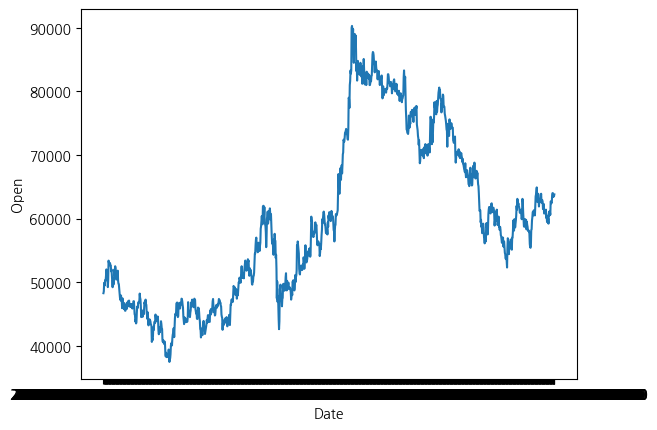

In [ ]:
# 일단 시각화 - 시가(Open)
sns.lineplot(data=data, x='Date', y='Open')
plt.show()

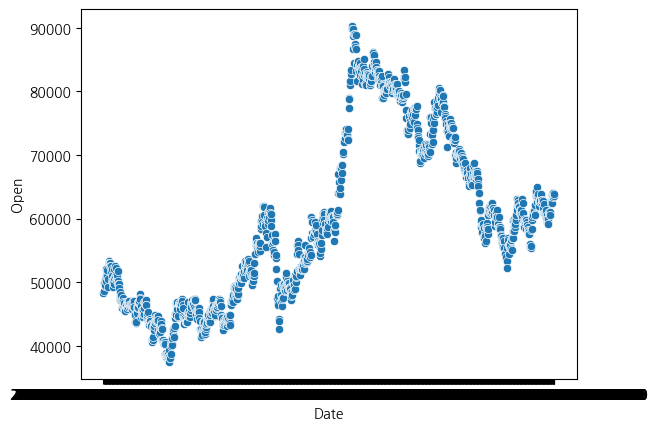

In [ ]:
# 일단 시각화 - 시가(Open) / 같은 데이터를 다양한 방법으로 시각화하면 보이지 않던 정보가 보인다.
sns.scatterplot(data=data, x='Date', y='Open', )
plt.show()

In [ ]:
# 자료형, 결측치 등 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231 entries, 0 to 1230
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1231 non-null   object 
 1   Open          1231 non-null   float64
 2   High          1231 non-null   float64
 3   Low           1231 non-null   float64
 4   Close         1231 non-null   float64
 5   Adj Close     1231 non-null   float64
 6   Volume        1231 non-null   int64  
 7   Dividends     1231 non-null   float64
 8   Stock Splits  1231 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 86.7+ KB


In [ ]:
# Date 컬럼 자료형 변환
data['Date'] = pd.to_datetime(data['Date'].str[:10], format='%Y-%m-%d')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231 entries, 0 to 1230
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1231 non-null   datetime64[ns]
 1   Open          1231 non-null   float64       
 2   High          1231 non-null   float64       
 3   Low           1231 non-null   float64       
 4   Close         1231 non-null   float64       
 5   Adj Close     1231 non-null   float64       
 6   Volume        1231 non-null   int64         
 7   Dividends     1231 non-null   float64       
 8   Stock Splits  1231 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 86.7 KB


In [ ]:
# 기초 통계량 정보 확인 (범주형 포함시 include='all')
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1231.0,5.946585e+04,1.309806e+04,37450.000000,4.735000e+04,5.800000e+04,7.015000e+04,9.030000e+04
High,1231.0,6.000318e+04,1.316961e+04,37600.000000,4.767500e+04,5.870000e+04,7.050000e+04,9.680000e+04
Low,1231.0,5.890539e+04,1.301888e+04,36850.000000,4.680000e+04,5.760000e+04,6.970000e+04,8.950000e+04
Close,1231.0,5.943385e+04,1.306675e+04,37450.000000,4.737500e+04,5.800000e+04,7.010000e+04,9.100000e+04
Adj Close,1231.0,5.607930e+04,1.400993e+04,33325.492188,4.244883e+04,5.516068e+04,6.813913e+04,8.721948e+04
Volume,1231.0,1.523444e+07,8.509279e+06,0.000000,1.005248e+07,1.362894e+07,1.826253e+07,9.030618e+07
Dividends,1231.0,6.791227e+00,6.967741e+01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.932000e+03
Stock Splits,1231.0,8.123477e-02,2.014556e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+01


- <font size=4>주식과 같은 시계열 데이터 이해</font>
    - 과거의 n일에 의하여 미래가 정해지는 개념으로 접근
    - 이동평균(MA, Moving Average): $x_{-n}$ ~ $x$일 평균 ➡ $x$일의 $n$일 이동평균
    - 장/단기 이동평균선간의 접점 : 골드크로스, 데드크로스
    - 조정종가(Adj CLose)
        - 기본 : 주가의 변동은 시장참여자의 수요와 공급으로 결정
        - 조정 : 액면분할, 배당금, 권리 등 주식에 영향을 줄만한 회사측의 영향을 반영한 종가

In [ ]:
# 상위 10개의 Adj Close 데이터에 대하여 5일간 rolling
pd.DataFrame(data['Adj Close'].rolling(window=5))[:10]

,0,1,2,3,4,5,6,7,8,9,...,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230
Adj Close,42735.472656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adj Close,42735.472656,42457.515625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adj Close,42735.472656,42457.515625,42440.148438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adj Close,42735.472656,42457.515625,42440.148438,42561.746094,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adj Close,42735.472656,42457.515625,42440.148438,42561.746094,43256.632812,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adj Close,NaN,42457.515625,42440.148438,42561.746094,43256.632812,43725.691406,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adj Close,NaN,NaN,42440.148438,42561.746094,43256.632812,43725.691406,43412.984375,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adj Close,NaN,NaN,NaN,42561.746094,43256.632812,43725.691406,43412.984375,44611.65625,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adj Close,NaN,NaN,NaN,NaN,43256.632812,43725.691406,43412.984375,44611.65625,45845.074219,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adj Close,NaN,NaN,NaN,NaN,NaN,43725.691406,43412.984375,44611.65625,45845.074219,44837.503906,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Adj Close 데이터에 대하여 5일 shift
# shift와 rolling 은 시계열에 자주 많이 등장하는데, 혼동하기 쉽다.
# shift와 rolling 의 차이점을 명확하게 이해 해야만 시계열 데이터를 분석할 수 있다.
data['Adj Close'].shift(5)

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
1226    62100.0
1227    62900.0
1228    62700.0
1229    63200.0
1230    64000.0
Name: Adj Close, Length: 1231, dtype: float64

In [ ]:
# 5, 20, 60, 120일 이동평균값 계산
ma5 = data['Adj Close'].rolling(window=5).mean()
ma20 = data['Adj Close'].rolling(window=20).mean()
ma60 = data['Adj Close'].rolling(window=60).mean()
ma120 = data['Adj Close'].rolling(window=120).mean()


In [ ]:
# 계산된 이동평균값 기존 데이터에 추가
data["MA5"] = ma5
data["MA20"] = ma20
data["MA60"] = ma60
data["MA120"] = ma120
data[:10]

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,MA5,MA20,MA60,MA120
0,2018-04-09,48260.0,49440.0,48200.0,49200.0,42735.472656,9950400,0.0,0.0,NaN,NaN,NaN,NaN
1,2018-04-10,48540.0,49220.0,48040.0,48880.0,42457.515625,10984350,0.0,0.0,NaN,NaN,NaN,NaN
2,2018-04-11,49900.0,49900.0,48600.0,48860.0,42440.148438,10051100,0.0,0.0,NaN,NaN,NaN,NaN
3,2018-04-12,49440.0,49440.0,48880.0,49000.0,42561.746094,12466250,0.0,0.0,NaN,NaN,NaN,NaN
4,2018-04-13,49600.0,50180.0,49400.0,49800.0,43256.632812,10278300,0.0,0.0,42690.303125,NaN,NaN,NaN
5,2018-04-16,50320.0,50600.0,49860.0,50340.0,43725.691406,7877450,0.0,0.0,42888.346875,NaN,NaN,NaN
6,2018-04-17,50240.0,50540.0,49820.0,49980.0,43412.984375,7772000,0.0,0.0,43079.440625,NaN,NaN,NaN
7,2018-04-18,51000.0,51360.0,50580.0,51360.0,44611.656250,13462600,0.0,0.0,43513.742188,NaN,NaN,NaN
8,2018-04-19,52000.0,52980.0,51540.0,52780.0,45845.074219,17190550,0.0,0.0,44170.407813,NaN,NaN,NaN
9,2018-04-20,51800.0,52260.0,51420.0,51620.0,44837.503906,11761000,0.0,0.0,44486.582031,NaN,NaN,NaN


- rolling 의 이해

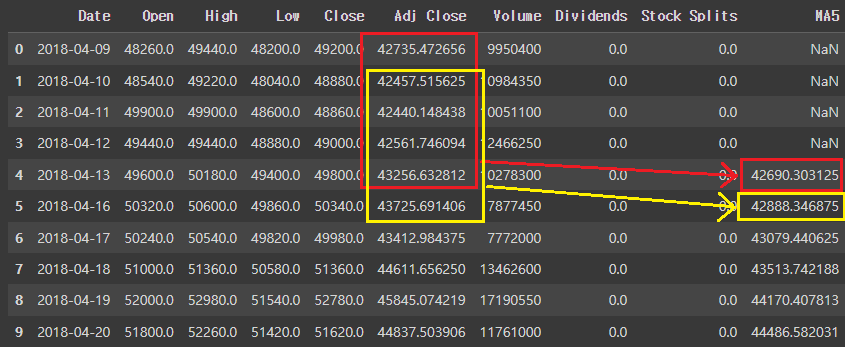

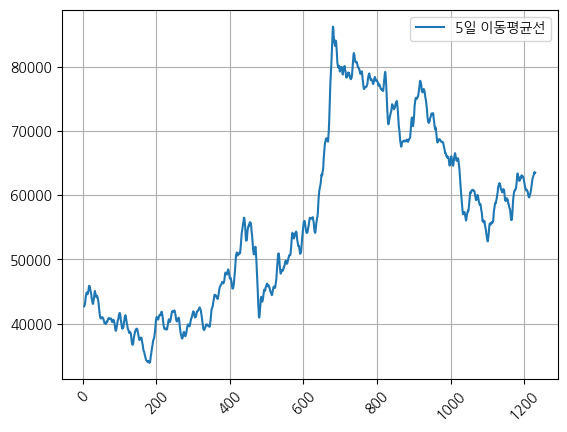

In [ ]:
# 이동평균선 시각화 방법 #1
plt.plot(data['MA5'], label="5일 이동평균선")
plt.legend(loc='best') # 라벨 위치 설정
plt.xticks(rotation=45) # x축 좌표각도
plt.grid()
plt.show()

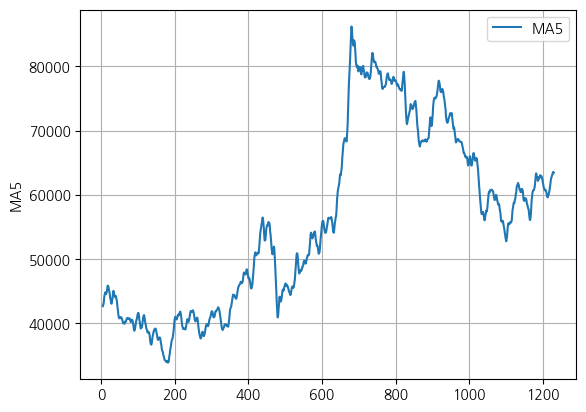

In [ ]:
# 이동평균선 시각화 방법 #2
# sns.lineplot(data=data['MA5'], label='MA5')
sns.lineplot(x=data['MA5'].index, y=data['MA5'], label='MA5')
plt.grid()
plt.show()

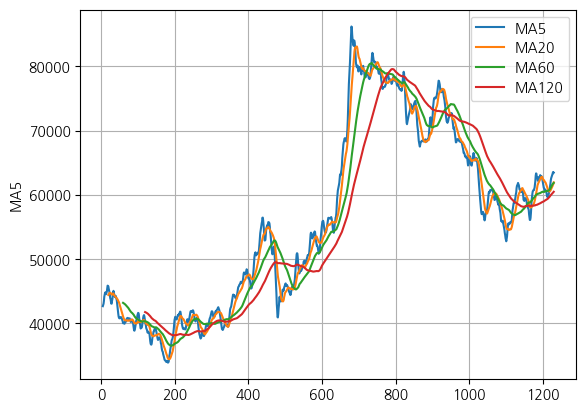

In [ ]:
# 모든 이동평균선 시각화
sns.lineplot(x=data['MA5'].index, y=data['MA5'], label='MA5')
sns.lineplot(x=data['MA20'].index, y=data['MA20'], label='MA20')
sns.lineplot(x=data['MA60'].index, y=data['MA60'], label='MA60')
sns.lineplot(x=data['MA120'].index, y=data['MA120'], label='MA120')
plt.grid()
plt.show()

- Feature Engineering 예제
  - Feature Engineering : 인공지능 모델에 적합한 데이터 또는 업무 도메인에 맞는 데이터를 생성(파생) 또는 선택

In [ ]:
# 금일 변동율 = (금일종가-전일종가) / 전일종가 * 100

In [ ]:
# 각 row 별 금일 변동율 계산 후 today_cr 컬럼에 저장
data['today_cr'] = (data['Close'] - data['Close'].shift(1)) / data['Close'].shift(1) * 100
data

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,MA5,MA20,MA60,MA120,ma5_shift,today_cr
0,2018-04-09,48260.0,49440.0,48200.0,49200.0,42735.472656,9950400,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-04-10,48540.0,49220.0,48040.0,48880.0,42457.515625,10984350,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-0.650407
2,2018-04-11,49900.0,49900.0,48600.0,48860.0,42440.148438,10051100,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-0.040917
3,2018-04-12,49440.0,49440.0,48880.0,49000.0,42561.746094,12466250,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.286533
4,2018-04-13,49600.0,50180.0,49400.0,49800.0,43256.632812,10278300,0.0,0.0,42690.303125,NaN,NaN,NaN,42735.472656,1.632653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,2023-04-03,64000.0,64000.0,63000.0,63100.0,63100.000000,11973133,0.0,0.0,63180.000000,61275.0,61606.666667,60232.288574,62900.000000,-1.406250
1227,2023-04-04,63400.0,63800.0,62800.0,63600.0,63600.000000,11120514,0.0,0.0,63320.000000,61420.0,61696.666667,60300.177832,62700.000000,0.792393
1228,2023-04-05,63700.0,64000.0,63400.0,63900.0,63900.000000,9176149,0.0,0.0,63560.000000,61600.0,61778.333333,60375.536003,63200.000000,0.471698
1229,2023-04-06,63500.0,63600.0,62300.0,62300.0,62300.000000,14992747,0.0,0.0,63380.000000,61710.0,61805.000000,60428.451139,64000.000000,-2.503912


In [ ]:
# 누적합계
data['cs_today_cr'] = data['today_cr'].cumsum()
data

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,MA5,MA20,MA60,MA120,ma5_shift,today_cr,cs_today_cr
0,2018-04-09,48260.0,49440.0,48200.0,49200.0,42735.472656,9950400,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-04-10,48540.0,49220.0,48040.0,48880.0,42457.515625,10984350,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-0.650407,-0.650407
2,2018-04-11,49900.0,49900.0,48600.0,48860.0,42440.148438,10051100,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-0.040917,-0.691323
3,2018-04-12,49440.0,49440.0,48880.0,49000.0,42561.746094,12466250,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.286533,-0.404790
4,2018-04-13,49600.0,50180.0,49400.0,49800.0,43256.632812,10278300,0.0,0.0,42690.303125,NaN,NaN,NaN,42735.472656,1.632653,1.227863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,2023-04-03,64000.0,64000.0,63000.0,63100.0,63100.000000,11973133,0.0,0.0,63180.000000,61275.0,61606.666667,60232.288574,62900.000000,-1.406250,40.802880
1227,2023-04-04,63400.0,63800.0,62800.0,63600.0,63600.000000,11120514,0.0,0.0,63320.000000,61420.0,61696.666667,60300.177832,62700.000000,0.792393,41.595273
1228,2023-04-05,63700.0,64000.0,63400.0,63900.0,63900.000000,9176149,0.0,0.0,63560.000000,61600.0,61778.333333,60375.536003,63200.000000,0.471698,42.066971
1229,2023-04-06,63500.0,63600.0,62300.0,62300.0,62300.000000,14992747,0.0,0.0,63380.000000,61710.0,61805.000000,60428.451139,64000.000000,-2.503912,39.563059


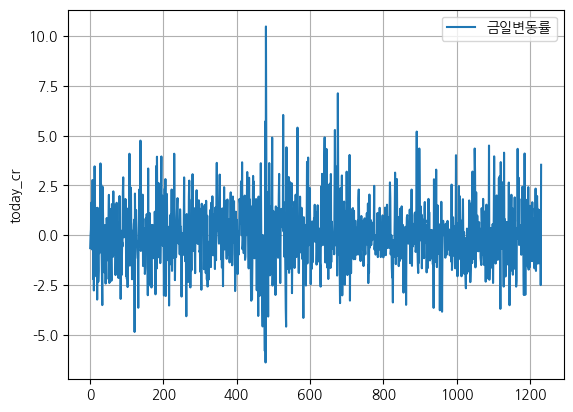

In [ ]:
# 금일변동률
sns.lineplot(x=data['today_cr'].index, y=data['today_cr'], label='금일변동률')
plt.grid()
plt.show()

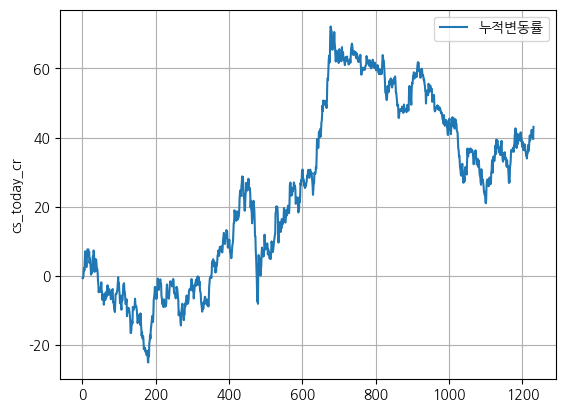

In [ ]:
# 누적합계 시각화
sns.lineplot(x=data['cs_today_cr'].index, y=data['cs_today_cr'], label='누적변동률')
plt.grid()
plt.show()

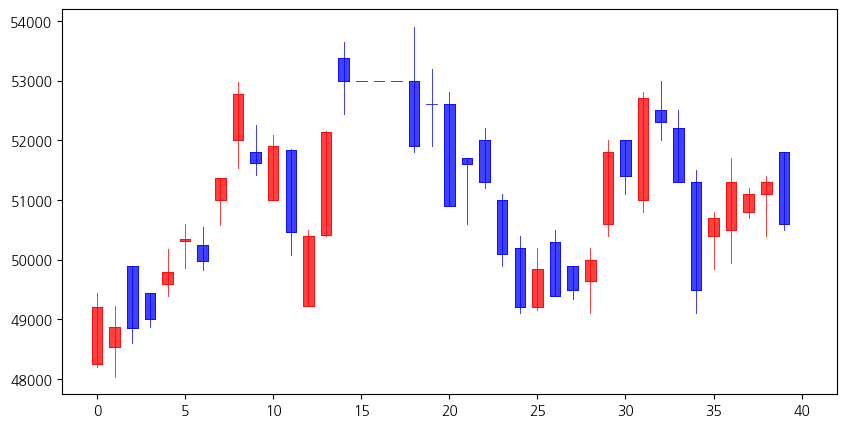

In [ ]:
# 봉 차트 #1
from mpl_finance import candlestick2_ohlc

fig, ax = plt.subplots(figsize=(10, 5))
data_temp = data[:40]
candlestick2_ohlc(ax, data_temp['Open'], data_temp['High'], data_temp['Low'], data_temp['Close'], width=0.6, colorup='r', colordown='b')
plt.show()

In [ ]:
# 봉 차트 #2
import plotly.graph_objects as go
import plotly.subplots as ms

# 캔들 차트 객체 생성
data_temp = data[:40]
candle = go.Candlestick(x=data_temp.index, open=data_temp['Open'], high=data_temp['High'], low=data_temp['Low'], close=data_temp['Close'],
                        increasing_line_color = 'red',
                        decreasing_line_color = 'blue'
)

fig = ms.make_subplots()
fig.add_trace(candle)
fig.show()


#### 분석결과 저장

In [ ]:
data.to_csv('samsun_stock.csv', index=False)

## 분석 이후에는 ?

- 분석 내용을 바탕으로 분석결과 파일을 이용하여 예측 모델 개발 (인공지능)
  - 인공지능 모델을 개발하여 예측 후 결과에 대한 분석과정이 필요함
- 추가 시각화를 수행하여 데이터 이해도 및 통찰력 제고
- 가장 중요한 것은 ! 최초의 분석 목적을 달성했는지 점검

# ☝ Tip! 전통적인 시계열 예측 (ARIMA)

- Autoregressive Integrated Moving Average (자기회귀 이동평균)

- 데이터 수집

In [1]:
# 기본 패키지 로드
import pandas as pd
import numpy as np

# 시각화 패키지 로드
import matplotlib.pyplot as plt
import seaborn as sns

# yahoo 에서 주식데이터 수집을 위한 패키지
import yfinance as yf

# 기타 패키지 로드
from tqdm import tqdm # 진행바 출력 

In [2]:
# 삼성전자 주식 정보 수신 및 저장
name = '005930.KS'
ticker = yf.Ticker(name)
df = ticker.history(interval='1d', period='5y', auto_adjust=False)
df.to_csv('005930.KS.csv')

In [6]:
# 저장된 삼성전자 주식 정보 읽기
data = pd.read_csv('005930.KS.csv')

# Date 컬럼 자료형 변환
data['Date'] = pd.to_datetime(data['Date'].str[:10], format='%Y-%m-%d')

data

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,2018-04-09,48260.0,49440.0,48200.0,49200.0,42735.468750,9950400,0.0,0.0
1,2018-04-10,48540.0,49220.0,48040.0,48880.0,42457.515625,10984350,0.0,0.0
2,2018-04-11,49900.0,49900.0,48600.0,48860.0,42440.144531,10051100,0.0,0.0
3,2018-04-12,49440.0,49440.0,48880.0,49000.0,42561.750000,12466250,0.0,0.0
4,2018-04-13,49600.0,50180.0,49400.0,49800.0,43256.628906,10278300,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1226,2023-04-03,64000.0,64000.0,63000.0,63100.0,63100.000000,11973133,0.0,0.0
1227,2023-04-04,63400.0,63800.0,62800.0,63600.0,63600.000000,11120514,0.0,0.0
1228,2023-04-05,63700.0,64000.0,63400.0,63900.0,63900.000000,9176149,0.0,0.0
1229,2023-04-06,63500.0,63600.0,62300.0,62300.0,62300.000000,14992747,0.0,0.0


In [7]:
# ARIMA 모델 개발을 위한 패키지 로드
import statsmodels.api as sm

- 시계열 모델 훈련 및 예측

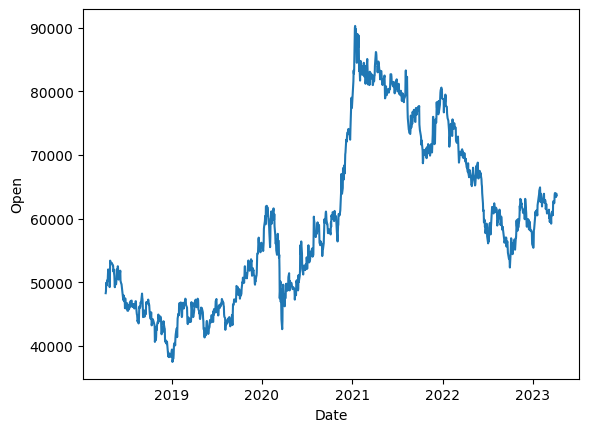

In [8]:
# 일단 시각화
sns.lineplot(data=data, x='Date', y='Open')
plt.show()

In [33]:
# ARIMA 모델을 학습한다.
# p, d, q : AR차수, 차분, MA차수
model = sm.tsa.arima.ARIMA(data['Open'].values[:-5], order = (2, 1, 3))
model = model.fit()

print(model.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1226
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -10230.757
Date:                Sat, 08 Apr 2023   AIC                          20473.515
Time:                        02:38:06   BIC                          20504.179
Sample:                             0   HQIC                         20485.054
                               - 1226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1239      0.065     17.366      0.000       0.997       1.251
ar.L2         -0.9117      0.065    -13.950      0.000      -1.040      -0.784
ma.L1         -1.1631      0.070    -16.717      0.0

In [34]:
# 앞으로 5일 데이터 예측
pred = model.forecast(steps=5)
pred

array([64011.63218829, 64054.73130325, 64068.71485552, 64045.13745016,
       64005.88973652])

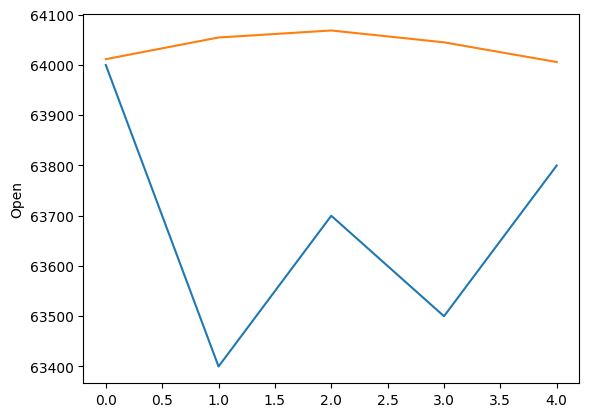

In [35]:
# 학습에 사용하지 않은 마지막 5일과
# 학습 후 예측한 5일 데이터를 한꺼번에 출력하여 모델 예측 결과 시각화
sns.lineplot(data=data[-5:], x=range(len(data[-5:])), y='Open')
sns.lineplot(x=range(len(pred)), y=pred)
plt.show()


- 모델의 성능을 높이기 위한 노력 !!!